# Point Cloud QoE Models

## Joint Communication and Computational Resource Allocation for QoE-driven Point Cloud Video Streaming

In [2]:
def get_distance_weight(g, k, d):
    # p_g,k in equation (5)
    # input: tile k in GOF g, distance d from the viewer to the object
    # output: for simplicity: all tiles have the same distance as d.
    return 1/d


0.3333333333333333


In [ ]:
def get_quality_weight(n, N):
    # QT_g,k in equation (5)
    # input: tile k in GOF g
    # output: the ratio of # of points in the tile k (n) to the total # of points in FOV (N)
    return n/N

In [ ]:
def get_quality_contribution(g, k, d, r):
    # output: quality contribution of tile k in GOF g with quality r at distance d
    distance_weight = get_distance_weight(g, k, d)
    quality_weight = get_quality_weight(n, N)

    return distance_weight * r * quality_weight


In [ ]:
def get_qoe_score (M, R, G, d):
    sum_1 = 0
    sum_2 = 0
    for g in range(G):
        for k in range(M):
            r = 1
            sum_1 += get_quality_contribution(g, k, d, r)
            sum_2 += get_quality_contribution(g, k, d, r) * R/r

    return sum_1/sum_2
    

## Objective metrics for PC compression

In [18]:
import re
import matplotlib.pyplot as plt

In [58]:
def calculate_frame_psnr(file):
    psnr_y = []
    psnr_cb = []
    psnr_cr = []
    psnr_color = []
    psnr_geometry = []

    with open(file) as f:
        lines = f.readlines()

        for line in lines:
            value = line.split(":")
            if len(value) > 1:
                if "c[0],PSNRF" in line:
                    psnr_y.append(float(value[1]))
                    continue

                if "c[1],PSNRF" in line:
                    psnr_cb.append(float(value[1]))
                    continue

                if "c[2],PSNRF" in line:
                    psnr_cr.append(float(value[1]))
                    continue
                if "mseF,PSNR" in line:
                    psnr_geometry.append(float(value[1]))
    
    # psnr_avg = 0
    for y, cb, cr in zip(psnr_y, psnr_cb, psnr_cr):
        psnr_color.append((4*y +cb + cr)/6)
        # psnr_avg += (4*y +cb + cr)/6

    # print("PSNR: ", psnr_frame)
    # f = open("psnr.txt", "a")
    # f.write("{}\t{}\n".format(file.split("/")[-1], psnr_frame))
    return psnr_color, psnr_geometry



In [62]:
result_folder = "./results"
videos = ["longdress", "soldier", "redandblack", "loot"]
qualities = ["r1", "r3", "r5"]
psnr_color = {}
psnr_geometry = {}

for video in videos:
    psnr_color[video] = {}
    psnr_geometry[video] = {}
    for quality in qualities:
        file = "{}/{}_{}_single.txt".format(result_folder, video, quality)
        psnr_color[video][quality], psnr_geometry[video][quality] = calculate_frame_psnr(file)

In [67]:
import numpy as np

video_psnr_color = {}
video_psnr_geometry = {}

for video in [videos[0], videos[3]]:
    video_psnr_color[video] = []
    for start in qualities:
        for end in qualities:
            psnr_frames_color = np.concatenate((psnr_color[video][start][:150], psnr_color[video][end][150:]))
            video_psnr_color[video].append(np.average(psnr_frames_color))
            print("{}_{}_{}_color: {}".format(video, start, end, np.average(psnr_frames_color)))

for video in [videos[0], videos[3]]:
    video_psnr_geometry[video] = []
    for start in qualities:
        for end in qualities:
            psnr_frames_geometry = np.concatenate((psnr_geometry[video][start][:150], psnr_geometry[video][end][150:]))
            video_psnr_geometry[video].append(np.average(psnr_frames_geometry))
            print("{}_{}_{}_geometry: {}".format(video, start, end, np.average(psnr_frames_geometry)))

longdress_r1_r1_color: 29.128674094388884
longdress_r1_r3_color: 31.190028283666663
longdress_r1_r5_color: 33.509734171722215
longdress_r3_r1_color: 31.182874472888887
longdress_r3_r3_color: 33.24422866216667
longdress_r3_r5_color: 35.56393455022222
longdress_r5_r1_color: 33.48259080827778
longdress_r5_r3_color: 35.543944997555556
longdress_r5_r5_color: 37.86365088561111
loot_r1_r1_color: 36.21263008427778
loot_r1_r3_color: 38.23265995561111
loot_r1_r5_color: 40.439309343333335
loot_r3_r1_color: 38.24862846022222
loot_r3_r3_color: 40.26865833155556
loot_r3_r5_color: 42.47530771927778
loot_r5_r1_color: 40.44640068244445
loot_r5_r3_color: 42.466430553777776
loot_r5_r5_color: 44.6730799415
longdress_r1_r1_geometry: 13.354453846133332
longdress_r1_r3_geometry: 14.874197726133334
longdress_r1_r5_geometry: 15.808332266133336
longdress_r3_r1_geometry: 14.873309609000001
longdress_r3_r3_geometry: 16.393053489
longdress_r3_r5_geometry: 17.327188029000002
longdress_r5_r1_geometry: 15.812999118
l

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.725754810906429 18.45839079311056
1.9936232756833814 28.319215252735663


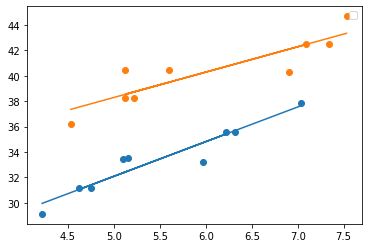

In [35]:
mos_longdress = np.array([4.21875, 4.75, 5.15625, 4.625, 5.96875, 6.21875, 5.09375, 6.3125, 7.03125])
mos_loot = np.array([4.53125, 5.21875, 5.59375, 5.125, 6.90625, 7.09375, 5.125, 7.34375, 7.53125])

plt.scatter(mos_longdress, video_psnr_color[videos[0]])
a, b = np.polyfit(mos_longdress, video_psnr_color[videos[0]], 1)
print(a, b)
plt.plot(mos_longdress, a*mos_longdress+b)

plt.scatter(mos_loot, video_psnr_color[videos[3]])
a, b = np.polyfit(mos_loot, video_psnr_color[videos[3]], 1)
print(a, b)
plt.plot(mos_loot, a*mos_loot+b)
plt.legend()

In [51]:
def linePlot(x, y, outputPath, title, legends, x_title, y_title):

    fig = plt.figure(figsize=(6, 4))

    i = 0
    for x_, y_ in zip(x,y):
        plt.scatter(x_, y_, label=legends[i])
        a, b = np.polyfit(x_, y_, 1)
        print(a, b)
        plt.plot(x_, a*x_+b)
        i += 1

    # plt.ylim(0,10)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.xlabel(x_title,fontsize=15)
    plt.ylabel(y_title,fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.savefig("{}/{}.pdf".format(outputPath, title))
    plt.show()

2.725754810906429 18.45839079311056
1.9936232756833814 28.319215252735663


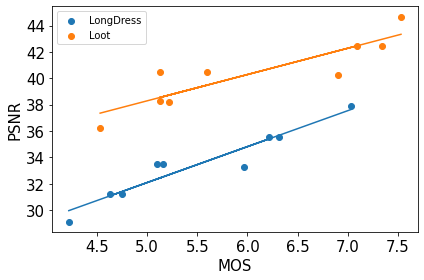

In [55]:
x = [mos_longdress, mos_loot]
y = [video_psnr_color[videos[0]], video_psnr_color[videos[3]]]

linePlot(x, y, "./figures", "PSNR_color",["LongDress", "Loot"], "MOS", "PSNR")

1.5809205805388555 7.331688995032665
1.3578569569141092 5.881806459009412


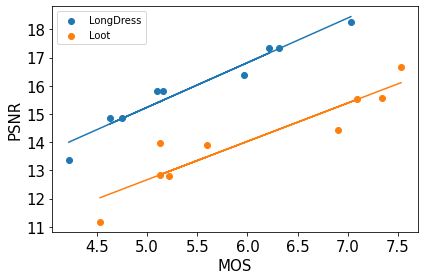

In [68]:
x = [mos_longdress, mos_loot]
y = [video_psnr_geometry[videos[0]], video_psnr_geometry[videos[3]]]

linePlot(x, y, "./figures", "PSNR_geometry",["LongDress", "Loot"], "MOS", "PSNR")

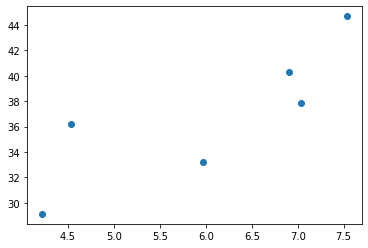

In [56]:
MOS = [4.53125, 6.90625, 7.53125, 4.21875, 5.96875, 7.03125]
PSNR = [36.216229541697885, 40.26865833155558, 44.67307994149996, 29.12867409438891, 33.244228662166634, 37.86365088561109]

plt.scatter(MOS, PSNR)


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

x = np.array([1.25, 2.5, 5])

# RedAndBlack
y_1 = np.array([3.1875, 3.6875, 4.78125])
model = LinearRegression()
model.fit(x.reshape((-1,1)), y_1)
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")
# data = [, [5.03125, 5.84375, 6.625], [6.1875, 6.5, 7.21875]]

intercept: 2.640625
slope: [0.42678571]


0.4267857142857146 2.6406249999999996


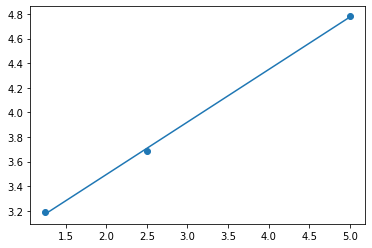

In [9]:
a, b = np.polyfit(x, y_1, 1)
print(a, b)
plt.scatter(x, y_1)
plt.plot(x, a*x+b)

0.40892857142857136 4.640625000000002


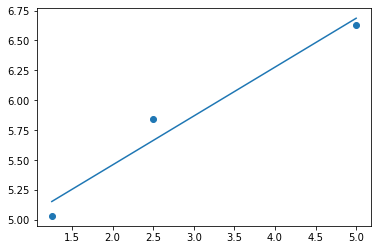

In [11]:
y_2 = np.array([5.03125, 5.84375, 6.625])
a, b = np.polyfit(x, y_2,1)
print(a, b)
plt.scatter(x, y_2)
plt.plot(x, a*x+b)

0.27678571428571463 5.828124999999998


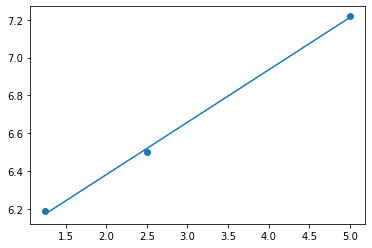

In [13]:
y_3 = np.array([6.1875, 6.5, 7.21875])
a,b = np.polyfit(x, y_3, 1)
print(a,b)
plt.scatter(x, y_3)
plt.plot(x,a*x+b)

0.45892857142857146 1.6406250000000002


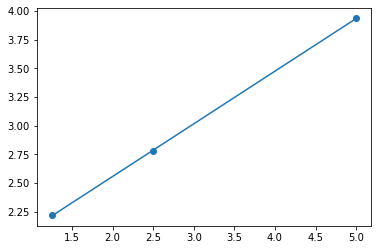

In [14]:
# Soldier
# [, [4.46875, 5.875, 6.34375], ]
y_1 = np.array([2.21875, 2.78125, 3.9375])
a,b = np.polyfit(x,y_1,1)
print(a,b)
plt.scatter(x,y_1)
plt.plot(x,a*x+b)

0.4553571428571427 4.234375000000002


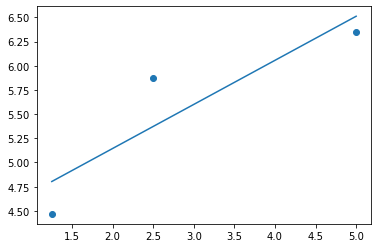

In [15]:
y_1 = np.array([4.46875, 5.875, 6.34375])
a,b = np.polyfit(x,y_1,1)
print(a,b)
plt.scatter(x,y_1)
plt.plot(x,a*x+b)

0.5267857142857145 5.078124999999998


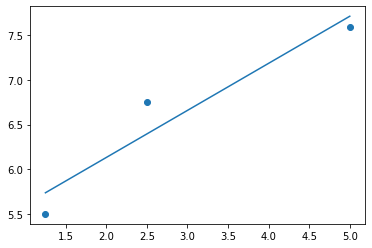

In [16]:
y_1 = np.array([5.5, 6.75, 7.59375])
a,b = np.polyfit(x,y_1,1)
print(a,b)
plt.scatter(x,y_1)
plt.plot(x,a*x+b)